<a href="https://colab.research.google.com/github/pilarang/RedColaboracionUNAM/blob/main/ETL_Descriptivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycountry

     |████████████████████████████████| 10.1MB 10.2MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746865 sha256=8b0a49aee0baab30793766dfbbd17480f21ef156d5d375a27fd1225e998af61c
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [ ]:
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import collections
import networkx as nx
from itertools import permutations
import matplotlib.pyplot as plt
import numpy as np

import pycountry
import seaborn as sns
import networkx as nx
import itertools

from collections import OrderedDict
from matplotlib import cm
from ast import literal_eval

ModuleNotFoundError: ignored

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (15,10)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = "1y_HXdE7eHkMXLhhyaE2pXX74znthWkum"
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('link_prediction_table.csv')  
df_links = pd.read_csv('link_prediction_table.csv',index_col=0,converters={'Authors': literal_eval})

# EDA

In [ ]:
df_links.head()

,Title,Type,Authors,Year,mdate,School/Publisher,Booktitle,Journal,Pages
0,File System Performance and Transaction Support.,PHDThesis,[Margo I. Seltzer],1992,2015-05-21,University of California at Berkeley,NaN,NaN,NaN
1,Tertiary Storage: An Evaluation of New Applica...,PHDThesis,[Ann L. Chervenak],1994,2002-01-03,U. C. Berkeley,NaN,NaN,NaN
2,Speicherung und Anfragebearbeitung komplexer G...,PHDThesis,[Michael Schiwietz],1993,2017-01-06,"Ludwig Maximilian University of Munich, Germany",NaN,NaN,NaN
3,The Temporal Deductive Database System ChronoLog,PHDThesis,[Michael H. Böhlen],1994,2002-01-03,"Departement Informatik, ETH Zürich",NaN,NaN,NaN
4,Design and specification of a program specific...,PHDThesis,[Saeed Parsa],1992,2016-10-06,"University of Salford, UK",NaN,NaN,NaN


In [ ]:

df_links.dtypes

Title               object
Type                object
Authors             object
Year                 int64
mdate               object
School/Publisher    object
Booktitle           object
Journal             object
Pages               object
dtype: object

In [ ]:

df_links.Type.value_counts(True)

Inproceedings    0.518193
Article          0.456032
PHDThesis        0.025775
Name: Type, dtype: float64

In [ ]:
print(df_links.Year.min(),df_links.Year.max())

1990 2000


In [ ]:

df_links['mYear'] = df_links.mdate.apply(lambda x: x[:4])
df_links['mMonth'] = df_links.mdate.apply(lambda x: x[:7])

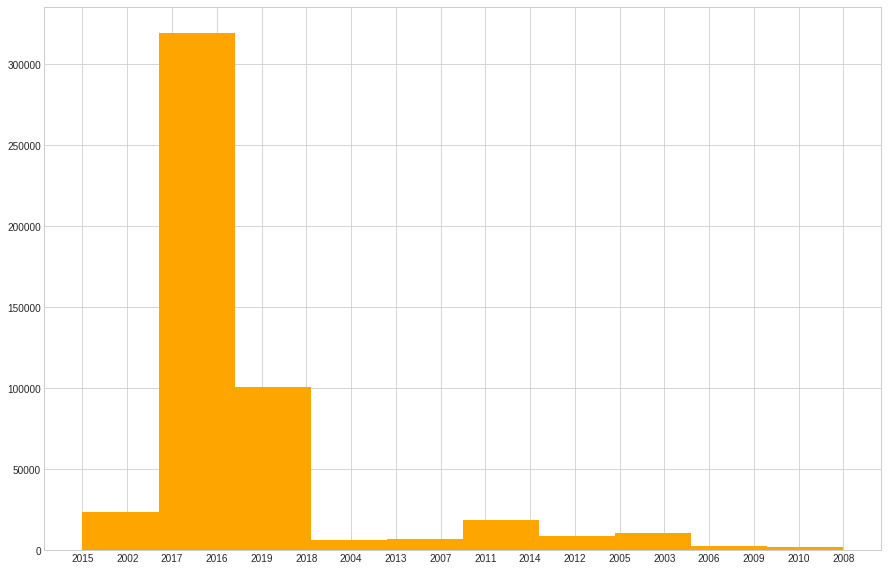

In [ ]:
fig = plt.figure(figsize=(15,10))
df_links.mYear.hist(color='orange')
plt.show()

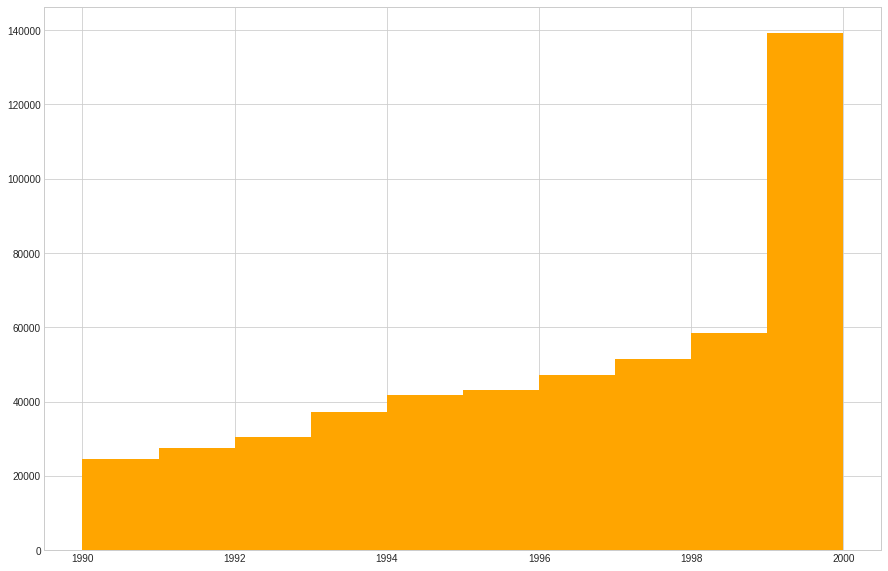

In [ ]:
df_links.Year.hist(color='orange')

In [ ]:
for x in df_links.Type.unique():
  print('*'*7+x+'*'*7)
  display(df_links[df_links.Type == x]['School/Publisher'].value_counts(dropna=False))

*******PHDThesis*******


Massachusetts Institute of Technology, Cambridge, MA, USA    576
Technical University Munich, Germany                         426
Karlsruhe Institute of Technology, Germany                   369
RWTH Aachen University, Germany                              345
Technical University of Berlin, Germany                      340
                                                            ... 
London Business School, UK                                     1
Ulster University,UK                                           1
University of Dortmund, Germany                                1
Technical University of Lisbon, Portugal                       1
VDI-Verlag                                                     1
Name: School/Publisher, Length: 636, dtype: int64

*******Inproceedings*******


NaN    259551
Name: School/Publisher, dtype: int64

*******Article*******


NaN    228416
Name: School/Publisher, dtype: int64

In [ ]:
names = []
for x in pycountry.countries:
    names.append(x.name)

In [ ]:
names.extend(['USA', 'U.C.'])


In [ ]:
df_links['Country'] = df_links['School/Publisher'].map(lambda text: '|'.join([word for word in names if word in text]) ,na_action='ignore')

In [ ]:
df_links['Country'].replace({'':np.nan,'France|Réunion':'France','USA':'United States of America'}, inplace=True)

In [ ]:
df_links['Country'].value_counts()

Germany                     6564
France                       888
United States of America     774
Brazil                       363
Switzerland                  340
Sweden                        95
Austria                       51
Hong Kong                     38
Netherlands                   27
Australia                     14
Finland                        8
Norway                         6
Belgium                        5
Canada                         4
Italy                          2
Poland                         1
Portugal                       1
Mexico                         1
Name: Country, dtype: int64

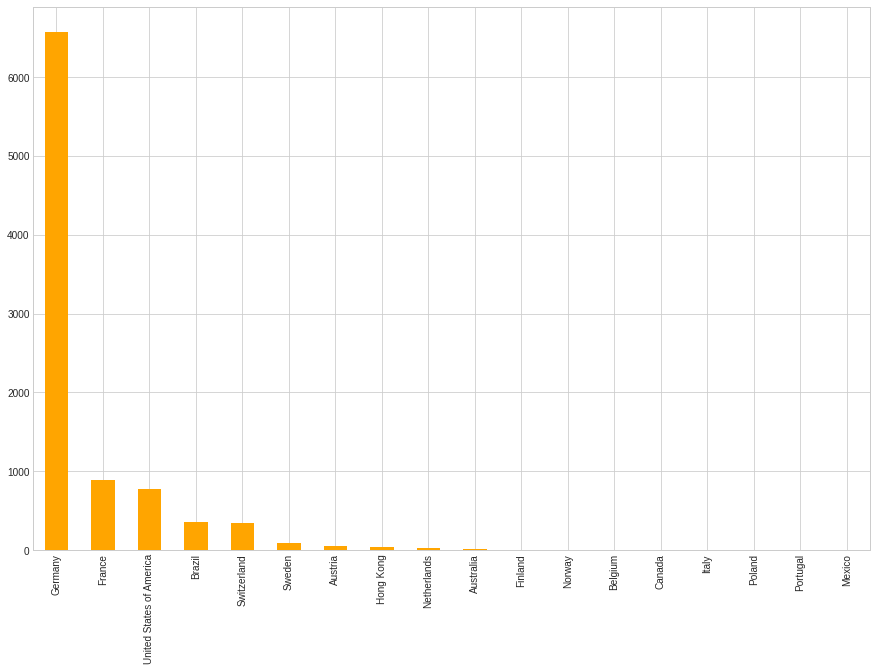

In [ ]:
df_links['Country'].value_counts().plot.bar(color='orange')

In [ ]:
ax = pd.DataFrame(df_links['Country'].value_counts()).reset_index().rename(columns={'index':'name'})

In [ ]:
ax

,name,Country
0,Germany,6564
1,France,888
2,United States of America,774
3,Brazil,363
4,Switzerland,340
5,Sweden,95
6,Austria,51
7,Hong Kong,38
8,Netherlands,27
9,Australia,14


In [ ]:
import geopandas

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [ ]:
w = world.merge(ax, on='name',how='left')

In [ ]:
w.fillna(0,inplace=True)

In [ ]:
w['pct']= w.Country/w.Country.sum()

In [ ]:
w[w.Country>0].shape

(17, 7)

In [ ]:
#w.plot(column='Country', cmap='copper_r')

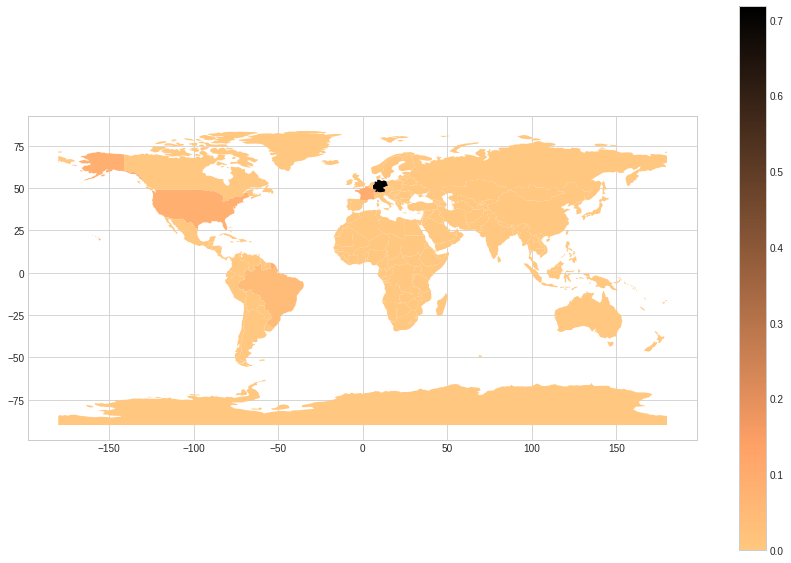

In [ ]:
fig, ax = plt.subplots(1, 1)

w.plot(column='pct', ax=ax, legend=True,cmap='copper_r')

In [ ]:
#w.plot(column='pct', cmap='copper_r')

Missing values

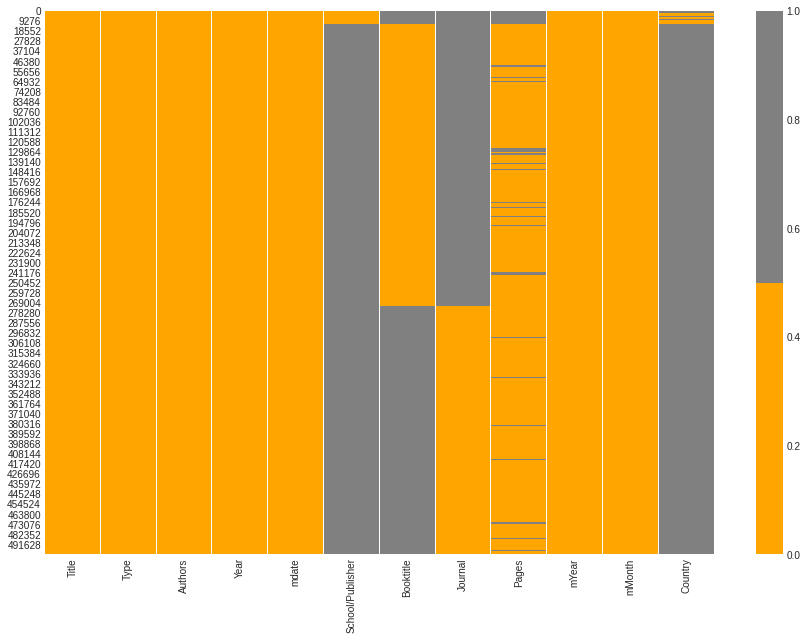

In [ ]:

colours = ['orange', 'gray'] 
sns.heatmap(df_links.isnull(), cmap=sns.color_palette(colours))

In [ ]:
for col in df_links.columns:
    pct_missing = np.mean(df_links[col].isnull())
    if (pct_missing > 0):
        #print(pct_missing)
        print('{} - {}%'.format(col, round(pct_missing*100)))

School/Publisher - 97.0%
Booktitle - 48.0%
Journal - 54.0%
Pages - 8.0%
Country - 98.0%


## Preguntas Descriptivas

* Top n de los autores con más coautorías
* Top n de los autores mejor conectados (con más conexiones)
* Histograma de colaboraciones por año
* Nube de palabras (títulos,revistas, por tipo de texto,sw,..)
* Histograma densidad número de colaboraciones por autor
* Contar los numeros de paginas 
* Minería de tópicos


In [ ]:
n = 10

##Top n de los autores con mas coautorías

In [ ]:
df_links['Authors_len'] = df_links.Authors.map(len)

NameError: ignored

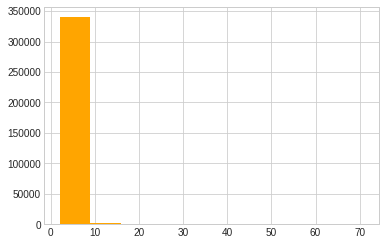

In [ ]:
df_links[df_links['Authors_len']>1].Authors_len.hist(color='orange')

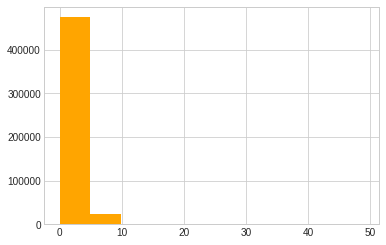

In [ ]:
df_links[df_links['Authors_len']<50].Authors_len.hist(color='orange')

In [ ]:
aux =pd.DataFrame(df_links[df_links['Authors_len']>1]['Authors'].explode().value_counts().head(n))

aux.reset_index(inplace=True)

aux.rename(columns={'index':'Author','Authors':'frec'},inplace=True)

colors = cm.OrRd_r(aux['frec']/ float(max(aux['frec'])))

KeyError: ignored

In [ ]:
plt.barh(aux['Author'].astype(str), aux['frec'], align='center', alpha=0.8, color=colors)
plt.yticks(aux['Author'].astype(str))
plt.title(str(n)+' autores con más contribuciones',fontsize=20)
plt.legend()
plt.show()

NameError: ignored

In [ ]:
nodes = df_links[df_links['Authors_len']>1]['Authors'].explode().to_list()

In [ ]:
nodes = list(set(nodes))

In [ ]:
edges = df_links[df_links['Authors_len']>1]['Authors'].map(lambda x: list(itertools.combinations(x,2))).explode()

In [ ]:
multiG_Co_authorship = nx.MultiGraph()

In [ ]:
multiG_Co_authorship.add_nodes_from(nodes)
multiG_Co_authorship.add_edges_from(edges)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
G_edges = multiG_Co_authorship.edges()

In [ ]:
weights = [len(multiG_Co_authorship[u][v]) for u,v in G_edges]

In [ ]:
lista = []
for u,v in G_edges:
    l = len(multiG_Co_authorship[u][v])
    lista.append([(u,v),l])

No handles with labels found to put in legend.


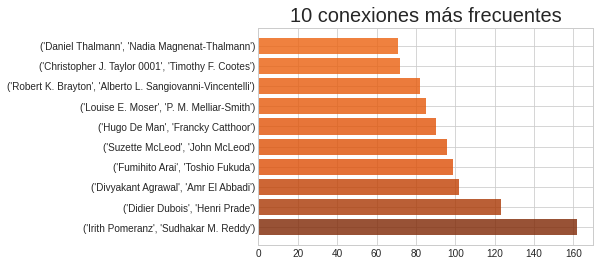

In [ ]:
df_G_edges_len = pd.DataFrame(lista, columns=['edges','edges_len']).drop_duplicates()
aux_edges = df_G_edges_len.sort_values(by='edges_len',ascending=False).head(n)
#colors = cm.hsv(aux_edges['edges_len']/ float(max(aux_edges['edges_len'])))
plt.barh(aux_edges['edges'].astype(str), aux_edges['edges_len'], align='center', alpha=0.8, color=colors)
plt.yticks(aux_edges['edges'].astype(str))
plt.title(str(n)+' conexiones más frecuentes',fontsize=20)
plt.legend()
plt.show()

## 2 Top n de los autores mejor conectados (con más conexiones)

In [ ]:
conexions = pd.DataFrame(nodes, columns=['name_authors'])

conexions['number_conexions'] = conexions.name_authors.apply(lambda x: len(multiG_Co_authorship[x]))

aux_con= conexions.sort_values(by='number_conexions', ascending=False).head(n)

y = aux_con['number_conexions']
#colors = cm.hsv(y/ float(max(y)))

plt.barh(aux_con['name_authors'], y, align='center', alpha=0.8,color=colors)
plt.yticks(aux_con['name_authors'])
plt.title(str(n)+' Autores con mas "contactos"',fontsize= 20)
plt.show()

NameError: ignored

## 3.Histograma de colaboraciones por año

In [ ]:
import plotly.graph_objects as go
import numpy as np
##*******************series*********************************
x0 = df_links[df_links.Type == 'Inproceedings']['Year']
x1 = df_links[df_links.Type == 'Article']['Year']
x2 = df_links[df_links.Type == 'PHDThesis']['Year']

fig = go.Figure()
##tantos trace como sea necesario puede ser solo uno
fig.add_trace(go.Histogram(
    x=x0,
    #histnorm='percent',
    name='Inproceedings', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=1950,
        end=2019,
        size=1
    ),
    marker_color='#FAA300',##naranja
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=x1,
    #histnorm='percent',
    name='Article', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=1950,
        end=2019,
        size=1
    ),
    marker_color='#FA5700' ,
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=x2,
    #histnorm='percent',
    name='PHDThesis', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=1950,
        end=2019,
        size=1
    ),
    marker_color='#7C4020 ',##naranja
    opacity=0.75
))
fig.update_layout(
    title_text='Distribución anual del número de publicaciones por tipo de publicación', # title of plot
    xaxis_title_text='Años', # xaxis label
    yaxis_title_text='Numero de publicaciones', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)
fig.show()

In [ ]:
df = pd.read_csv('link_prediction_table.csv', index_col=0)
df['Title'] = df['Title'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #se remueve palabras cortas
df['Authors'] = df['Authors'].apply(lambda x: x.replace('\'','').strip('][').split(', '))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
df.head()

,Title,Type,Authors,Year,mdate,School/Publisher,Booktitle,Journal,Pages
0,File System Performance Transaction Support.,PHDThesis,[Margo I. Seltzer],1992,2015-05-21,University of California at Berkeley,NaN,NaN,NaN
1,Tertiary Storage: Evaluation Applications,PHDThesis,[Ann L. Chervenak],1994,2002-01-03,U. C. Berkeley,NaN,NaN,NaN
2,Speicherung Anfragebearbeitung komplexer Geo-O...,PHDThesis,[Michael Schiwietz],1993,2017-01-06,"Ludwig Maximilian University of Munich, Germany",NaN,NaN,NaN
3,Temporal Deductive Database System ChronoLog,PHDThesis,[Michael H. Böhlen],1994,2002-01-03,"Departement Informatik, ETH Zürich",NaN,NaN,NaN
4,Design specification program specification lan...,PHDThesis,[Saeed Parsa],1992,2016-10-06,"University of Salford, UK",NaN,NaN,NaN


### Top n de los autores con más coautorías

In [ ]:
coautorias = {}
for authors in df.Authors.values:
    if len(authors) >= 2:
        for author in authors:
            if author in coautorias:
                coautorias[author] += 1
            else:
                coautorias[author] = 1
     

In [ ]:
df_popularidad = pd.DataFrame(coautorias.keys(), columns = ['Nombre'])
df_popularidad['Coautorias'] = coautorias.values() 
df_popularidad.sort_values(by = ['Coautorias'], ascending = False)

,Nombre,Coautorias
8062,Toshio Fukuda,274
5602,Kang G. Shin,237
18451,Alberto L. Sangiovanni-Vincentelli,221
2711,Thomas S. Huang,199
5616,Sudhakar M. Reddy,198
...,...,...
155472,Xiaoyuan Luo,1
155473,Ertan Onur,1
155476,Maunu Holma,1
155477,Sami Kekki,1


### Top n de los autores con más coautorías

In [ ]:
G = nx.Graph()  # or DiGraph, MultiGraph, MultiDiGraph, etc

for authors in df.Authors.values:
    if len(authors) >= 2:
        for permutation in permutations(authors, 2):
            G.add_edge(*permutation)


## Contar los numeros de paginas

In [ ]:
def numero_paginas(x):
    if '-' in x:
        temp = x.split('-')
        if not temp[0].isnumeric() or not temp[1].isnumeric():
            return 0
        if temp[1]:
            return int(temp[1]) - int(temp[0])
        else:
            return int(temp[0])
    else:
        if not x.isnumeric():
            return 0
        return int(x)

In [ ]:
ah_df = df_links.copy()
ah_df = ah_df.loc[ah_df['Pages'].notna()]
ah_df['Pages'] = ah_df['Pages'].apply(numero_paginas)

In [ ]:
from scipy import stats
ah_df = ah_df[(np.abs(stats.zscore(df_links)) < 3).all(axis=1)]


In [ ]:

fig = plt.figure(figsize=(10,8))
sns.boxplot(data = ah_df, y = 'Pages')
plt.show()

### Minería de Tópicos



In [ ]:

vectorizer = TfidfVectorizer(stop_words='english', 
                            max_features= 1000,
                            max_df = 0.5, 
                            smooth_idf=True)

X = vectorizer.fit_transform(df['Title'])
print("Tamaño de la matriz T-D: ", X.shape) # visualizamos el tamaño de la matriz

In [ ]:

svd_model = TruncatedSVD(n_components=30, 
                        algorithm='randomized', 
                         n_iter=200, 
                         random_state=122)
svd_model.fit(X)

In [ ]:
terms = vectorizer.get_feature_names()

#Visualizamos algunas de las plabras más importantes en cada uno de los 20 tópicos
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key = lambda x:x[1], reverse=True)[:10]
    dict_terms = {e[0]:e[1] for e in sorted_terms}
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate_from_frequencies(dict_terms)# Plot
    plt.figure(figsize=(10, 30))
    #     Display image
    plt.title("Tópico "+str(i+1))
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.plot()